In [1]:
!git clone https://github.com/carrn/Shude_waveforms.git

Cloning into 'Shude_waveforms'...
fatal: could not read Username for 'https://github.com': No such device or address


In [1]:
# Importing packages 
# --- Importing matplotlib, seaborn, etc.

import os
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET


In [2]:
!pip install networkx==2.4
import networkx as nx

!pip install scikit-learn==0.22.2.post1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

!pip install xgboost==1.0.2
import xgboost as xgb

!pip install umap-learn==0.5.0
from umap import umap_ as umap

!pip install cylouvain==0.2.2
import cylouvain

!pip install shap==0.35
import shap

!pip install python-igraph==0.8.2
import igraph as ig

  Attempting uninstall: networkx
    Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Created wheel for umap-learn: filename=umap_learn-0.5.0-py3-none-any.whl size=76334 sha256=aac5c03a33fcc5e14fc57a63daff5891066eac8ecbc353c8a58444d7eb0799e0
  Stored in directory: c:\users\ncarr\appdata\local\pip\cache\wheels\65\12\35\bfcdbe79e089f9c294c7d0e2e63e06d1cdec98e5cf60c9cdd6
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52587 sha256=0a9d9336577f2823485e1016614f69c8c953d7f2951fbb8f066425d3ad96606b
  Stored in directory: c:\users\ncarr\appdata\local\pip\cache\wheels\e4\0e\b5\07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built umap-learn pynndescent


LoweringError: Failed in nopython mode pipeline (step: nopython mode backend)
[1m[1mStoring i64 to ptr of i32 ('dim'). FE type int32
[1m
File "..\..\..\Anaconda3\lib\site-packages\umap\layouts.py", line 52:[0m
[1mdef rdist(x, y):
    <source elided>
    result = 0.0
[1m    dim = x.shape[0]
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: lowering "dim = static_getitem(value=$8load_attr.2, index=0, index_var=$const10.3, fn=<built-in function getitem>)" at C:\Users\ncarr\Anaconda3\lib\site-packages\umap\layouts.py (52)[0m

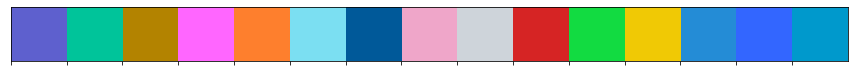

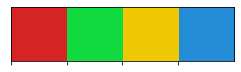

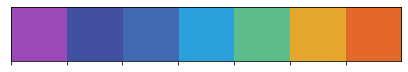

In [3]:
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#b38300','#ff66ff','#fe7f2d','#7bdff2','#005999','#efa6c9','#ced4da','#d62424','#12db41','#f0c905','#248cd6', '#3366ff','#0099cc']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283,	0.724],
[0.259,	0.314, 0.635],
[0.251,	0.412, 0.698],
[0.176,	0.631, 0.859],
[0.369,	0.749, 0.549],
[0.898,	0.654, 0.169],
[0.898,	0.41, 0.165]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [25]:
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 48 samples per waveform colleted at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(48/30000) 

#Setting of random seed across Python kernel and packages to ensure reproducibility 
RAND_STATE=42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph. 
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS = 30

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#Louvain Clustering Parameters
RESOLUTION = 2.0

# BLUE COLOR
BlueCol = '\033[94m'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print(BlueCol + 'Loading data')

rel_path = os.getcwd()
fullDataPath = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/normalizednegwaveforms.mat');
#fullDataPath = os.path.join(rel_path,'WaveMAP_Paper/data/normalizedposwaveforms.mat');
#fullDataPath = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/normalizedwaveforms.mat');
#GMMclasslabelpath = os.path.join(rel_path,'WaveMAP_Paper/data/waveformsClassified_250hz_refiltered.mat')
#GMMfeaturepath = os.path.join(rel_path,'WaveMAP_Paper/data/gmm_features.mat')
#BICpath = os.path.join(rel_path,'WaveMAP_Paper/data/BIC_list.mat')
#eightclassGMMpath = os.path.join(rel_path,'WaveMAP_Paper/data/8_class_GMM.mat');
filtfulldfPath = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/depth.mat');

#print(rel_path)
print(fullDataPath);
#print(GMMclasslabelpath)
#print(GMMfeaturepath)
#print(BICpath)
#print(eightclassGMMpath)
#print(filtfulldfPath)

full_data = scipy.io.loadmat(fullDataPath)['align_neg']
#full_data = scipy.io.loadmat(fullDataPath)['align_pos']
#full_data = scipy.io.loadmat(fullDataPath)['align_all']
depth_data = scipy.io.loadmat(filtfulldfPath)['depth_neg']
print(full_data.shape)
print(depth_data.shape)


#allDataDFPath = os.path.join(rel_path,'WaveMAP_Paper/data/full_data_df.pkl');

#GMM_class_labels = scipy.io.loadmat(GMMclasslabelpath)['classifies'].T
#gmm_features_data = scipy.io.loadmat(GMMfeaturepath)['features']

#GMM_class_labels = GMM_class_labels[~np.isnan(GMM_class_labels)]
#GMM_class_df = pd.DataFrame(GMM_class_labels,columns=['Class'])
#gmm_feat_data_nonan = gmm_features_data[~np.isnan(gmm_features_data)].reshape(len(GMM_class_df),3)

#BIC_list = scipy.io.loadmat(BICpath)['BIC_list'][0]

#eight_GMM_classes = scipy.io.loadmat(eightclassGMMpath)['classifies']

#all_data_df = pkl.load(open(allDataDFPath,'rb'))
#filt_full_df = pkl.load(open(filtfulldfPath,"rb"))

#print(allDataDFPath)

Loading data
/content/drive/MyDrive/Chand Lab/Shude Data/normalizednegwaveforms.mat
(738, 52)
(738, 1)


Plotting: 738 Waveforms


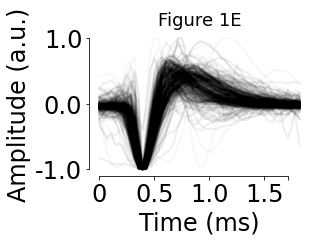

In [7]:
# This plots all the normalized single unit waveforms together. The total waveform length is 48 points at 30000 samples/s
# 14, 28, 42 are the 0.5 ms, 1.0 ms, and 1.5 ms

# Generate subplots
f, arr = plt.subplots(1,figsize=[4.5,3.4])

print(BlueCol + "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i].T, c = 'k', alpha = 0.03,linewidth=2.);
    
arr.tick_params(direction='out',colors='k', axis='both')
    
# Set various x and y axes and labels etc.
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)

arr.spines['left'].set_bounds(-1,1)
arr.spines['bottom'].set_bounds(0,48)

arr.set_xlabel('Time (ms)', fontsize=24);
arr.set_xticks([0,14,28,42,48])
arr.set_xticklabels(['0','0.5','1.0','1.5',''],fontsize=24)

arr.set_ylabel('Amplitude (a.u.)', fontsize=24)
arr.set_yticks([-1.0,0.0,1.0]);
arr.set_yticklabels([-1.0,0.0,1.0], fontsize=24);

arr.set_title('Figure 1E', fontsize=18)

# Plot the data
plt.tight_layout()

In [26]:
reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist=MIN_DIST, 
                    random_state=RAND_STATE)
mapper = reducer.fit(full_data)
embedding = reducer.transform(full_data)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(full_data)

In [27]:
G = nx.from_scipy_sparse_matrix(mapper.graph_)
clustering = cylouvain.best_partition(G, resolution = RESOLUTION)
clustering_solution = list(clustering.values())
umap_df['color'] = clustering_solution

cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in clustering_solution]
print(len(clustering_solution))


738


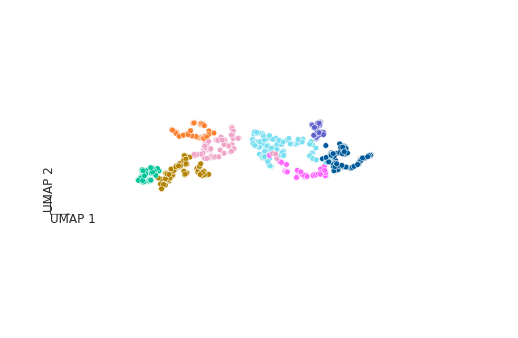

In [28]:
f,arr = plt.subplots(1,figsize=[7,4.5],tight_layout = {'pad': 0});
f.tight_layout()
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o', c=cluster_colors, s=32, edgecolor='w',
            linewidth=0.5)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xticks([]);
arr.set_yticks([]);
arr.set_xlim(-10,25)
arr.set_ylim(-10,20)

arr.arrow(-7,0.8,0,1.5, width=0.05, shape="full", ec="none", fc="black")
arr.arrow(-7,0.8,1.2,0, width=0.05, shape="full", ec="none", fc="black")

arr.text(-7,0.3,"UMAP 1", va="center")
arr.text(-7.5,1.0,"UMAP 2",rotation=90, ha="left", va="bottom")

N_CLUST = len(set(clustering_solution))

In [29]:
# Defines a nice function that plots all the waveforms in long column.
def plot_group(label_ix, labels, groups_df, colors, mean_only=False, detailed=False):
    group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
    group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()
    
    f, arr = plt.subplots()
    f.set_figheight(1.8*0.65)
    f.set_figwidth(3.0*0.65)
    if not mean_only:
        for i,_ in enumerate(group_waveforms):
            plt.plot(group_waveforms[i],c=colors[label_ix-1],alpha=0.3,linewidth=1.5)
    
    if not mean_only:
        plt.plot(np.mean(group_waveforms,axis=0),c='k',linestyle='-')
    else:
        plt.plot(np.mean(group_waveforms,axis=0),c=colors[label_ix-1],linestyle='-')

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)

    if detailed:
        
        avg_peak = np.mean([np.argmax(x) for x in group_waveforms[14:]])
        arr.axvline(avg_peak,color='k',zorder=0)
        
        arr.set_ylim([-1.3,1.3])
        arr.set_yticks([])
        arr.set_xticks([0,7,14,21,28,35,42,48])
        arr.tick_params(axis='both', which='major', labelsize=12)
        arr.set_xticklabels([0,'',0.5,'',1.0,'',1.5,''])
        arr.spines['left'].set_visible(False)
        arr.grid(False)
        arr.set_xlim([0,48])

    if not detailed:
        arr.set(xticks=[],yticks=[])

        if not mean_only:
            x,y = 2.1,0.7
            ellipse = mpl.patches.Ellipse((x,y), width=9.0, height=0.72, facecolor='w',
                                 edgecolor='k',linewidth=1.5)
            label = arr.annotate(str(label_ix), xy=(x-0.25, y-0.15),fontsize=12, color = 'k', ha="center")
            arr.add_patch(ellipse)

            if i != -1:
                x, y = 23,-0.7
                n_waveforms = plt.text(x, y, 
                                       'n = '+str(len(group_waveforms))+
                                       ' ('+str(round(len(group_waveforms)/len(groups_df)*100,2))+'%)'
                                       , fontsize=10)
    
    return f, arr

Mean of empty slice.
invalid value encountered in double_scalars


UnboundLocalError: ignored

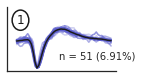

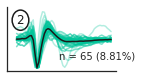

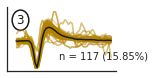

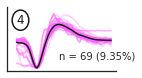

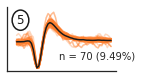

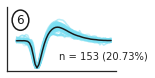

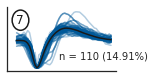

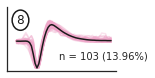

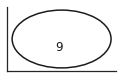

In [30]:
BSclass = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] #, 16, 17, 18, 19, 20]
#posclass = [1, 2, 3, 4, 5]
#BSclass = [ 6, 15, 10, 11 ,14 ]
#NSclass = [12, 13, 9, 16,  7, 8]
#for i in posclass:
#    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)

for i in BSclass:
    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)
    

#for i in NSclass:
#    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)


       a           b
0    1.0 -649.403731
1    7.0  402.892005
2    2.0  529.628465
3    4.0  504.003047
4    7.0  558.110284
..   ...         ...
733  7.0  272.163400
734  5.0    7.600989
735  6.0   48.483169
736  6.0 -176.724191
737  6.0  198.328524

[738 rows x 2 columns]


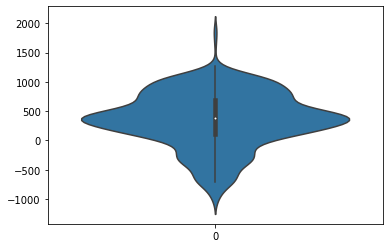

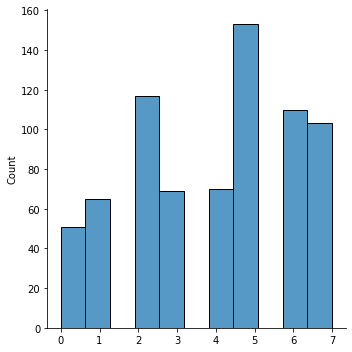

In [14]:
g = np.transpose(np.array([clustering_solution]))
m = np.column_stack((g,depth_data))
n = pd.Series([m])
df = pd.DataFrame(m,columns=list("ab"))
print(df)


b = plt.subplot(sns.violinplot(data=depth_data))

c = sns.displot(data=clustering_solution)



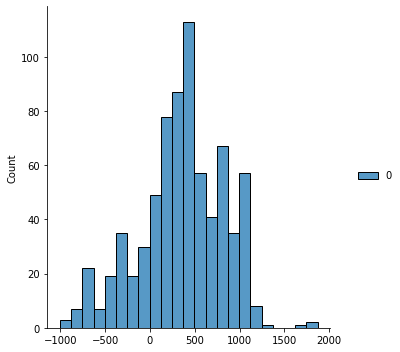

In [15]:
#for i in enumerate(1,15):
sns.displot(data=depth_data)

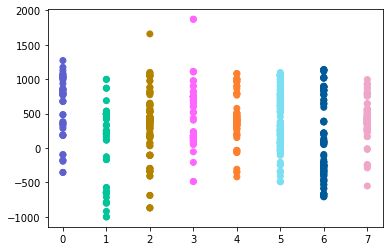

In [16]:
plt.scatter(g,depth_data,c=cluster_colors)



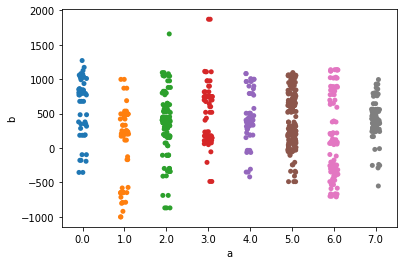

In [17]:
sns.stripplot(x='a', y='b',data=df)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


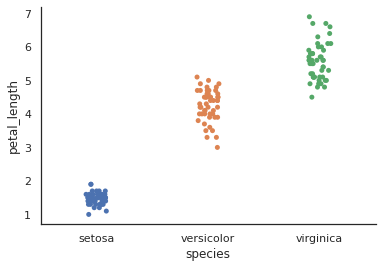

In [18]:
iris = sns.load_dataset('iris')
sns.set(style="white", color_codes=True)
sns.stripplot(x='species', y='petal_length', data=iris)
sns.despine()
print(iris)